In [157]:
import socket, math, struct, time

def logsock():
    phoneipnumber = "10.0.38.88"
    hanglogport = 9042
    addr1 = socket.getaddrinfo(phoneipnumber, hanglogport)[0][-1]
    s1 = socket.socket()
    s1.connect(addr1)
    s1.send(b"-@@@")
    return s1

def loglines(s1):
    rf = [ ]
    while True:
        r = s1.recv(10)
        while b"\n" in r:
            rr, r = r.split(b"\n", 1)
            rf.append(rr)
            yield b"".join(rf).decode()
            rf.clear()
        rf.append(r)

s1 = logsock()


In [162]:
# get 10 seconds of combined camera and orientation data
llns = loglines(s1)
print(next(llns))

t0 = time.time()
for l in llns:
    if l[1] == "C":
        t0 = time.time()
    elif time.time() > t0 + 3:
        break
        
print("waitforcamera")
for l in llns:
    if l[1] == "C":
        break

t0 = time.time()
print("start")
llcam, llorient = [ ], [ ]
for l in llns:
    if time.time() > t0 + 10:
        break
    if l[1] == "C":
        llcam.append(l)
    elif l[1] == "Z":
        llorient.append(l)
print("stop", len(llcam), len(llorient))


aZt000077F8xFABCyFC38zC99C
waitforcamera
start
stop 174 166


In [163]:
# convert from ll lines to pandas tables
import cv2, numpy, pandas
seqcam, seqorient = [ ], [ ]

def s4(s):
    j = int(s, 16)
    return (j if j < 32768 else j - 65536);

def convquattoeuler(q0, q1, q2, q3):
    riqsq = q0 * q0 + q1 * q1 + q2 * q2 + q3 * q3;
    iqsq = 1.0 / riqsq;
    r02 = q0 * q2 * 2 * iqsq 
    r13 = q1 * q3 * 2 * iqsq
    sinpitch = r13 - r02;
    r01 = q0 * q1 * 2 * iqsq 
    r23 = q2 * q3 * 2 * iqsq
    sinroll = r23 + r01;
    r00 = q0 * q0 * 2 * iqsq 
    r11 = q1 * q1 * 2 * iqsq 
    r03 = q0 * q3 * 2 * iqsq 
    r12 = q1 * q2 * 2 * iqsq
    a00 = r00 - 1 + r11 
    a01 = r12 + r03;
    rads = math.atan2(a00, -a01);

    northorientA = 180 - math.degrees(rads);
    pitchA = math.degrees(math.asin(sinpitch));
    rollA = math.degrees(math.asin(sinroll));
    return pitchA, rollA, northorientA

def processaZ(l):
    t = int(l[3:11], 16)
    q1 = s4(l[12:16])/32768.0
    q2 = s4(l[17:21])/32768.0
    q3 = s4(l[22:26])/32768.0
    q0 = math.sqrt(max(0.0, 1.0 - (q1*q1 + q2*q2 + q3*q3)));
    pitchA, rollA, northorientA = convquattoeuler(q0, q1, q2, q3)
    return t*0.001, pitchA, rollA, northorientA
        
def processaC(l):
    t = int(l[3:11], 16)
    bk = struct.pack(">QQQQQQ", int(l[12:28], 16), int(l[29:45], 16), int(l[46:62], 16), int(l[63:79], 16), int(l[80:96], 16), int(l[97:123], 16))
    rvec0, rvec1, rvec2, tvec0, tvec1, tvec2 = struct.unpack(">dddddd",bk)
    m = cv2.Rodrigues(numpy.array([rvec0, rvec1, rvec2]))[0]
    mz = m[2]
    pitchC = math.degrees(-math.asin(m[0][2]))
    rollC = math.degrees(-math.asin(m[1][2]))
    northorientC = 180+math.degrees(math.atan2(m[1][0], m[1][1]))
    return t*0.001, pitchC, rollC, northorientC

seqcam = [ processaC(l)  for l in llcam ]
seqorient = [ processaZ(l)  for l in llorient ]
dfcam = pandas.DataFrame.from_records(seqcam, columns=["t", "pitch", "roll", "northorient"])
dforient = pandas.DataFrame.from_records(seqorient, columns=["t", "pitch", "roll", "northorient"])
dfcam.set_index("t", inplace=True)
dforient.set_index("t", inplace=True)
dfcam.index.name = None
dforient.index.name = None

def unwindheading(h):
    return h + 360*numpy.cumsum((h.diff() < -180)*1 - (h.diff() > 180)*1)
dforient.northorient = unwindheading(dforient.northorient)
dfcam.northorient = unwindheading(dfcam.northorient)


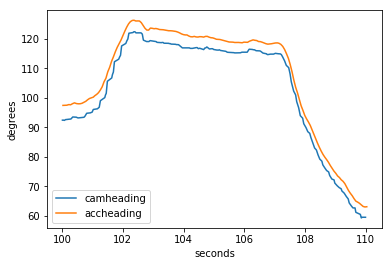

In [164]:
plt.plot(dfcam.northorient, label="camheading")
plt.plot(dforient.northorient, label="accheading")
plt.xlabel("seconds")
plt.ylabel("degrees")
plt.legend()


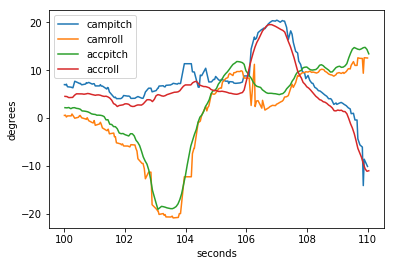

In [165]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(dfcam.pitch, label="campitch")
plt.plot(dfcam.roll, label="camroll")
plt.plot(dforient.pitch, label="accpitch")
plt.plot(dforient.roll, label="accroll")
plt.xlabel("seconds")
plt.ylabel("degrees")
plt.legend()
